In [17]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rich import print
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (
    PredictionErrorDisplay,
    mean_squared_error,
    median_absolute_error,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    RepeatedKFold,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

%load_ext rich
pd.set_option("display.max_columns", None)


The rich extension is already loaded. To reload it, use:
  %reload_ext rich


In [2]:
data = pd.read_csv('../data/spotify_songs_train.csv')

In [3]:
X = data.drop(columns=['track_popularity'])
y = data['track_popularity']

X

,track_id,track_name,track_artist,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.102000,0.000000,0.0653,0.5180,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.726,0.815,11,-4.969,1,0.0373,0.072400,0.004210,0.3570,0.6930,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.079400,0.000023,0.1100,0.6130,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.028700,0.000009,0.2040,0.2770,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.080300,0.000000,0.0833,0.7250,123.976,189052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29545,0aBDrRTgDCwWbcOnEIp7DJ,Many Ways - Radio Edit,Ferry Corsten feat. Jenny Wahlstrom,59XOfNjuYZB6feC6QUzS3e,Many Ways,2013,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,progressive electro house,0.581,0.640,5,-8.367,1,0.0365,0.026600,0.000000,0.5720,0.2880,128.001,196993
29546,7bxnKAamR3snQ1VGLuVfC1,City Of Lights - Official Radio Edit,Lush & Simon,2azRoBBWEEEYhqV6sb7JrT,City Of Lights (Vocal Mix),2014-04-28,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,progressive electro house,0.428,0.922,2,-1.814,1,0.0936,0.076600,0.000000,0.0668,0.2100,128.170,204375
29547,5Aevni09Em4575077nkWHz,Closer - Sultan & Ned Shepard Remix,Tegan and Sara,6kD6KLxj7s8eCE3ABvAyf5,Closer Remixed,2013-03-08,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,progressive electro house,0.522,0.786,0,-4.462,1,0.0420,0.001710,0.004270,0.3750,0.4000,128.041,353120
29548,7ImMqPP3Q1yfUHvsdn7wEo,Sweet Surrender - Radio Edit,Starkillers,0ltWNSY9JgxoIZO4VzuCa6,Sweet Surrender (Radio Edit),2014-04-21,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,progressive electro house,0.529,0.821,6,-4.899,0,0.0481,0.108000,0.000001,0.1500,0.4360,127.989,210112


In [4]:
features = [
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
]

X = X[features]

### Train-test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

y_train


29549    27
21399    85
24404    52
4338      3
10128     6
         ..
21575    29
5390     57
860      31
15795     5
23654    30
Name: track_popularity, Length: 23640, dtype: int64

## Model building

### Stacked ensemble

In [25]:
estimators = [("knn", KNeighborsRegressor()), ("ridge", Ridge())]

final_estimator = LinearRegression()

stacked_reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator, n_jobs=-1, verbose=2
)

stacked_reg


StackingRegressor(estimators=[('knn', KNeighborsRegressor()),
                              ('ridge', Ridge())],
                  final_estimator=LinearRegression(), n_jobs=-1, verbose=2)

In [26]:
print(stacked_reg)

StackingRegressor(estimators=[('knn', KNeighborsRegressor()),
                              ('ridge', Ridge())],
                  final_estimator=LinearRegression(), n_jobs=-1, verbose=2)

#### RandomizedSearchCV

In [31]:
param_grid = {
    "knn__n_neighbors": [3, 5, 7],
    "ridge__alpha": [0.1, 1, 10],
}

search = RandomizedSearchCV(
    stacked_reg,
    param_distributions=param_grid,
    n_iter=5,
    random_state=42,
    n_jobs=-1,
    verbose=2,
    cv=5,
    scoring="neg_mean_squared_error",
)

search.fit(X_train, y_train)

print(f"Best params: {search.best_params_}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Best params: {'ridge__alpha': 0.1, 'knn__n_neighbors': 3}

Best score: -553.9095528433736

In [32]:
train_rmse = np.sqrt(-search.best_score_)
print(f"Train RMSE: {train_rmse}")


Train RMSE: 23.53528314772044

In [29]:
best_model = search.best_estimator_
best_model

best_model.fit(X_train, y_train)


StackingRegressor(estimators=[('knn', KNeighborsRegressor(n_neighbors=3)),
                              ('ridge', Ridge(alpha=0.1))],
                  final_estimator=LinearRegression(), n_jobs=-1, verbose=2)

In [30]:
y_pred = best_model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {test_rmse:.2f}")


Test RMSE: 23.53

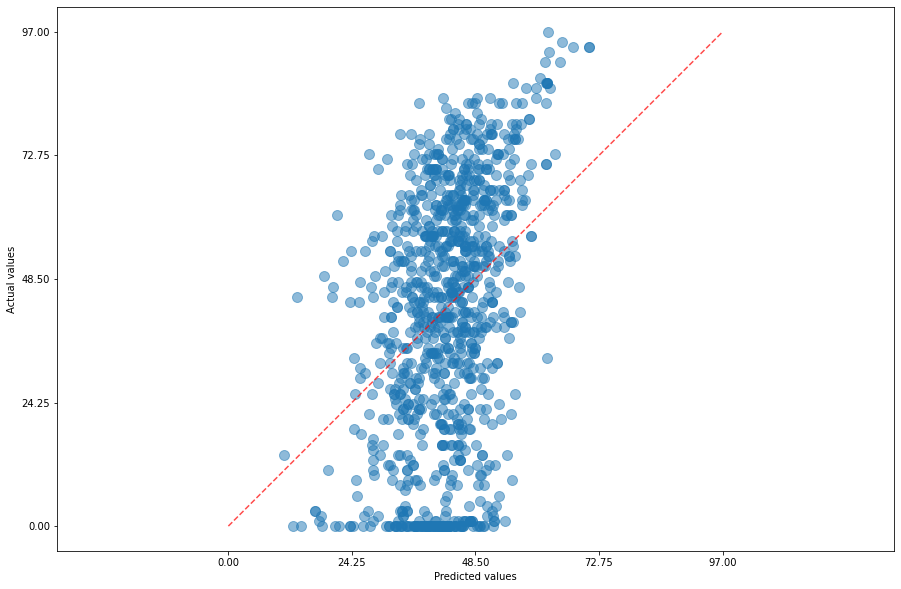

In [41]:
fig, ax = plt.subplots(figsize=(15, 10))

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred,
    kind="actual_vs_predicted",
    random_state=42,
    ax=ax,
    scatter_kwargs=dict(s=100, alpha=0.5),
    line_kwargs=dict(linestyle="--", color="red"),
)

plt.show()
